In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [7]:
models = {'SGD': Net(False, False, 'SGD', lr=1e-3),
          'momentum': Net(False, False, 'SGD', lr=1e-3, momentum=0.9),
          'Adadelta': Net(False, False, 'Adadelta', lr=1.),
          'RMSProp': Net(False, False, 'RMSProp', lr=1e-2),
          'Adam': Net(False, False, 'Adam', lr=1e-3), 
         }
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [9]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [10]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses SGD: 2.3290 momentum: 2.3675 Adadelta: 2.2857 RMSProp: 2.3930 Adam: 2.3024
Train Epoch: 1 [10000/50000 (20%)]	Losses SGD: 2.3140 momentum: 2.3285 Adadelta: 0.4463 RMSProp: 0.5349 Adam: 0.5101
Train Epoch: 1 [20000/50000 (40%)]	Losses SGD: 2.3033 momentum: 2.2751 Adadelta: 0.2352 RMSProp: 0.4357 Adam: 0.2310
Train Epoch: 1 [30000/50000 (60%)]	Losses SGD: 2.3089 momentum: 2.2037 Adadelta: 0.1256 RMSProp: 0.3194 Adam: 0.2328
Train Epoch: 1 [40000/50000 (80%)]	Losses SGD: 2.2960 momentum: 1.8090 Adadelta: 0.1447 RMSProp: 0.3828 Adam: 0.1596
Train Epoch: 1 [50000/50000 (100%)]	Losses SGD: 2.2919 momentum: 1.4106 Adadelta: 0.0980 RMSProp: 0.3228 Adam: 0.2125
Test set:
SGD: Loss: 2.3010	Accuracy: 1108.0/10000 (11%)
momentum: Loss: 1.3665	Accuracy: 7059.0/10000 (71%)
Adadelta: Loss: 0.1170	Accuracy: 9641.0/10000 (96%)
RMSProp: Loss: 0.2003	Accuracy: 9401.0/10000 (94%)
Adam: Loss: 0.1581	Accuracy: 9566.0/10000 (96%)

Train Epoch: 2 [0/50000 (0%)]	Losses SGD:

Train Epoch: 9 [50000/50000 (100%)]	Losses SGD: 2.0295 momentum: 0.2734 Adadelta: 0.0226 RMSProp: 0.0576 Adam: 0.0468
Test set:
SGD: Loss: 2.0242	Accuracy: 5300.0/10000 (53%)
momentum: Loss: 0.2010	Accuracy: 9452.0/10000 (95%)
Adadelta: Loss: 0.0511	Accuracy: 9853.0/10000 (99%)
RMSProp: Loss: 0.0792	Accuracy: 9767.0/10000 (98%)
Adam: Loss: 0.0479	Accuracy: 9860.0/10000 (99%)

Train Epoch: 10 [0/50000 (0%)]	Losses SGD: 2.0267 momentum: 0.1886 Adadelta: 0.0064 RMSProp: 0.0159 Adam: 0.0079
Train Epoch: 10 [10000/50000 (20%)]	Losses SGD: 2.0161 momentum: 0.3075 Adadelta: 0.1056 RMSProp: 0.1914 Adam: 0.0984
Train Epoch: 10 [20000/50000 (40%)]	Losses SGD: 2.0007 momentum: 0.2481 Adadelta: 0.0329 RMSProp: 0.1228 Adam: 0.0345
Train Epoch: 10 [30000/50000 (60%)]	Losses SGD: 1.9824 momentum: 0.2798 Adadelta: 0.0118 RMSProp: 0.0342 Adam: 0.0190
Train Epoch: 10 [40000/50000 (80%)]	Losses SGD: 1.9385 momentum: 0.1670 Adadelta: 0.0414 RMSProp: 0.0905 Adam: 0.0059
Train Epoch: 10 [50000/50000 (100%)]

Train Epoch: 18 [10000/50000 (20%)]	Losses SGD: 0.9637 momentum: 0.1177 Adadelta: 0.0012 RMSProp: 0.0100 Adam: 0.0018
Train Epoch: 18 [20000/50000 (40%)]	Losses SGD: 0.9276 momentum: 0.1625 Adadelta: 0.0329 RMSProp: 0.0685 Adam: 0.0124
Train Epoch: 18 [30000/50000 (60%)]	Losses SGD: 0.9665 momentum: 0.3093 Adadelta: 0.0225 RMSProp: 0.0847 Adam: 0.0227
Train Epoch: 18 [40000/50000 (80%)]	Losses SGD: 0.5513 momentum: 0.0514 Adadelta: 0.0151 RMSProp: 0.0107 Adam: 0.0145
Train Epoch: 18 [50000/50000 (100%)]	Losses SGD: 0.7531 momentum: 0.0885 Adadelta: 0.0590 RMSProp: 0.1376 Adam: 0.0158
Test set:
SGD: Loss: 0.7198	Accuracy: 8246.0/10000 (82%)
momentum: Loss: 0.1288	Accuracy: 9613.0/10000 (96%)
Adadelta: Loss: 0.0463	Accuracy: 9871.0/10000 (99%)
RMSProp: Loss: 0.0843	Accuracy: 9764.0/10000 (98%)
Adam: Loss: 0.0468	Accuracy: 9862.0/10000 (99%)

Train Epoch: 19 [0/50000 (0%)]	Losses SGD: 0.7803 momentum: 0.2883 Adadelta: 0.0436 RMSProp: 0.0704 Adam: 0.0149
Train Epoch: 19 [10000/50000 (20%)]

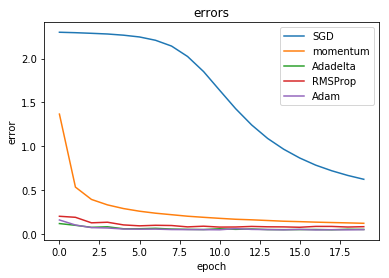

In [11]:
plot_graphs(test_log, 'loss')

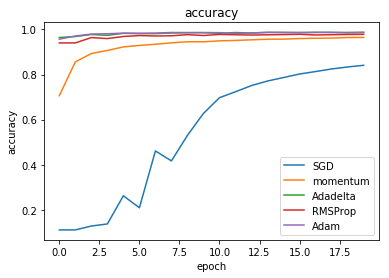

In [12]:
plot_graphs(test_log, 'accuracy')

In [13]:
?optim.ASGD